In [1]:
import tensorflow as tf
from src.dataset import dataset_tf, validation_tf, validate_on
from src.audio import to_mfccs_dataset, to_spectrogram_dataset
from src.model import get_seq_model, get_conv_model, callbacks, get_conv_model_mini
from src.plots import plot_history, plot_mfccs, plot_spectrograms
import numpy as np
LEARNING_RATE = 0.0001

0.90 - For proving that using pre-trained model works better

In [2]:
# train_ds, val_ds, label_names = dataset_tf("./dataset/sbcm_hive_1_train_copy", 0.30, 16)
# train_ds, val_ds, label_names = dataset_tf("./dataset/pitched_transformed_train", 0.50, 16)
train_ds, val_ds, label_names = dataset_tf("dataset/osbh_sep_1", 0.60, 8)

Found 130 files belonging to 2 classes.
Using 52 files for training.
Using 78 files for validation.
label names: ['noqueen' 'queen']
(TensorSpec(shape=(None, 4000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Example audio shape: (8, 4000)
Example label shape: (8,)


2024-03-30 11:28:52.894201: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-03-30 11:28:52.894231: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-03-30 11:28:52.894242: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-03-30 11:28:52.894278: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-30 11:28:52.894304: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


513 44100
Label: queen
Waveform shape: (4000,)
MFCCs shape: (12, 16)
Spectrogram shape: (118, 129, 1)
513 44100
Label: noqueen
Waveform shape: (4000,)
MFCCs shape: (12, 16)
Spectrogram shape: (118, 129, 1)


In [3]:
train_mfccs_ds = to_mfccs_dataset(train_ds)
val_mfccs_ds = to_mfccs_dataset(val_ds)
train_spectrogram_ds = to_spectrogram_dataset(train_ds)
val_spectrogram_ds = to_spectrogram_dataset(val_ds)

513 44100
513 44100


# Train raw models

## Raw - MFCCs

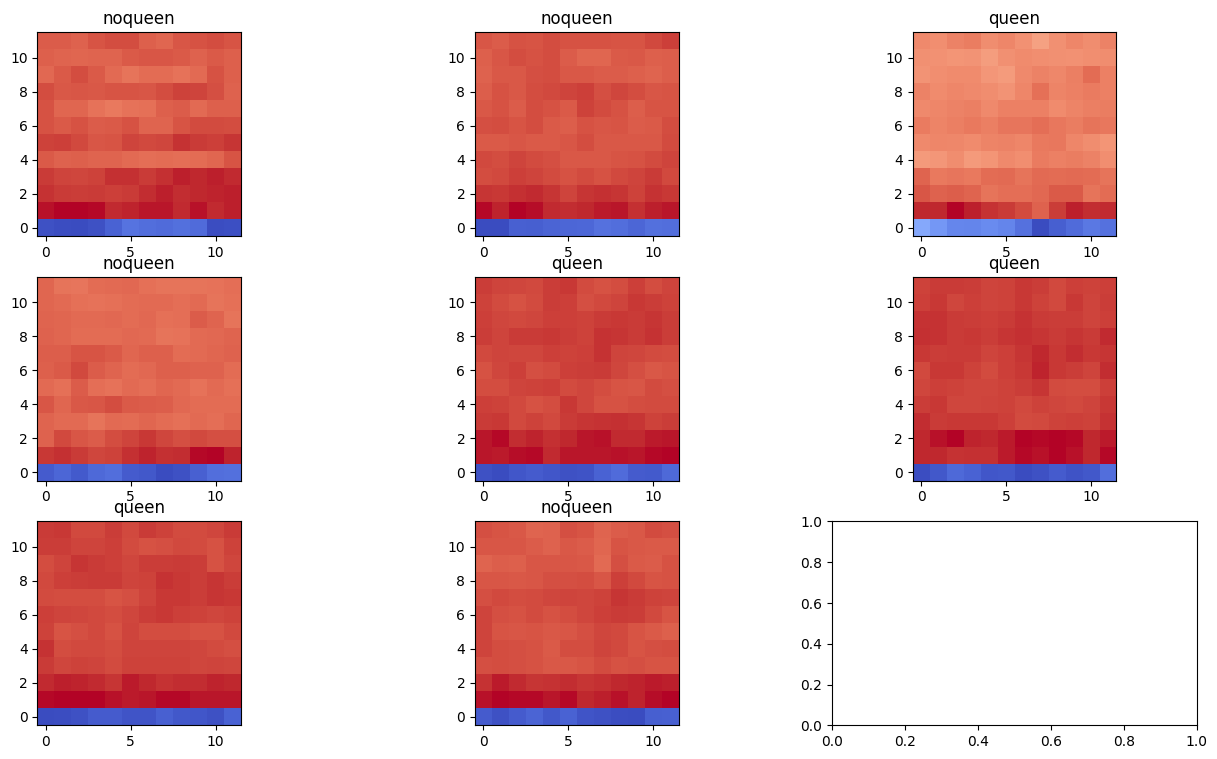

In [4]:
for example_mfccs, example_mfccs_labels in train_mfccs_ds.take(1):
  break

plot_mfccs(example_mfccs, example_mfccs_labels, label_names)

In [5]:
train_mfccs_ds = train_mfccs_ds.map(lambda x, y: (tf.expand_dims(x, -1), y))
val_mfccs_ds = val_mfccs_ds.map(lambda x, y: (tf.expand_dims(x, -1), y))

for example_mfccs, example_mfccs_labels in train_mfccs_ds.take(1):
  break
input_shape = example_mfccs.shape[1:]
input_shape

TensorShape([12, 12, 1])

In [6]:
train_mfccs_ds = train_mfccs_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_mfccs_ds = val_mfccs_ds.cache().prefetch(tf.data.AUTOTUNE)

### [Reinf:Raw] [MFCCs] Sequential Model

2024-03-30 11:28:54.388919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Epoch 1/20


2024-03-30 11:28:54.927087: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


7/7 [==============================] - 1s 79ms/step - loss: 0.7253 - accuracy: 0.5385 - val_loss: 0.6819 - val_accuracy: 0.6026
Epoch 2/20
7/7 [==============================] - 0s 23ms/step - loss: 0.6773 - accuracy: 0.6346 - val_loss: 0.7034 - val_accuracy: 0.3974
Epoch 3/20
7/7 [==============================] - 0s 21ms/step - loss: 0.6691 - accuracy: 0.6154 - val_loss: 0.6659 - val_accuracy: 0.7821
Epoch 4/20
7/7 [==============================] - 0s 26ms/step - loss: 0.6212 - accuracy: 0.6154 - val_loss: 0.6530 - val_accuracy: 0.6410
Epoch 5/20
7/7 [==============================] - 0s 21ms/step - loss: 0.6034 - accuracy: 0.6538 - val_loss: 0.6404 - val_accuracy: 0.6026
Epoch 6/20
7/7 [==============================] - 0s 23ms/step - loss: 0.5822 - accuracy: 0.7115 - val_loss: 0.6282 - val_accuracy: 0.6026


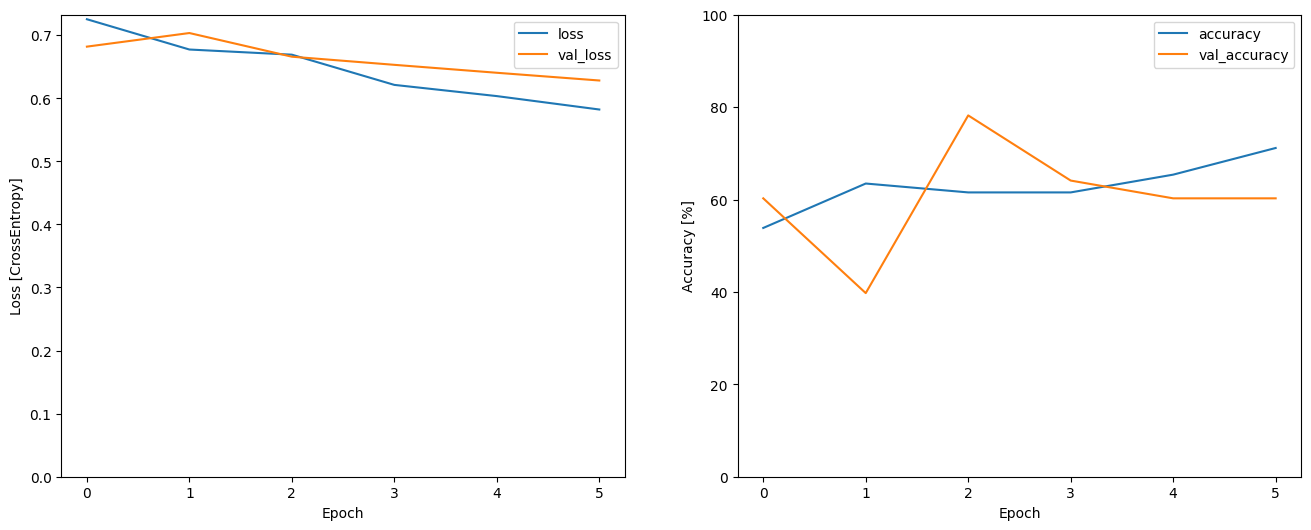

In [7]:
model_mfcc_seq = get_seq_model(input_shape, len(label_names), train_mfccs_ds)
model_mfcc_seq.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
history_mfcc_seq = model_mfcc_seq.fit(
    train_mfccs_ds,
    validation_data=val_mfccs_ds,
    epochs=20,
    callbacks=callbacks
)
plot_history(history_mfcc_seq)

### [Reinf:Raw] [MFCCs] Convolutional Model (mini)

Epoch 1/20
7/7 [==============================] - 1s 109ms/step - loss: 0.8206 - accuracy: 0.4423 - val_loss: 0.7985 - val_accuracy: 0.3462
Epoch 2/20
7/7 [==============================] - 0s 11ms/step - loss: 0.7775 - accuracy: 0.3462 - val_loss: 0.7552 - val_accuracy: 0.3718
Epoch 3/20
7/7 [==============================] - 0s 10ms/step - loss: 0.7397 - accuracy: 0.4615 - val_loss: 0.7360 - val_accuracy: 0.4359
Epoch 4/20
7/7 [==============================] - 0s 10ms/step - loss: 0.7282 - accuracy: 0.5192 - val_loss: 0.7228 - val_accuracy: 0.4872
Epoch 5/20
7/7 [==============================] - 0s 11ms/step - loss: 0.7181 - accuracy: 0.4615 - val_loss: 0.7116 - val_accuracy: 0.5897
Epoch 6/20
7/7 [==============================] - 0s 11ms/step - loss: 0.7057 - accuracy: 0.5385 - val_loss: 0.7006 - val_accuracy: 0.5385
Epoch 7/20
7/7 [==============================] - 0s 10ms/step - loss: 0.6908 - accuracy: 0.5962 - val_loss: 0.6904 - val_accuracy: 0.5385


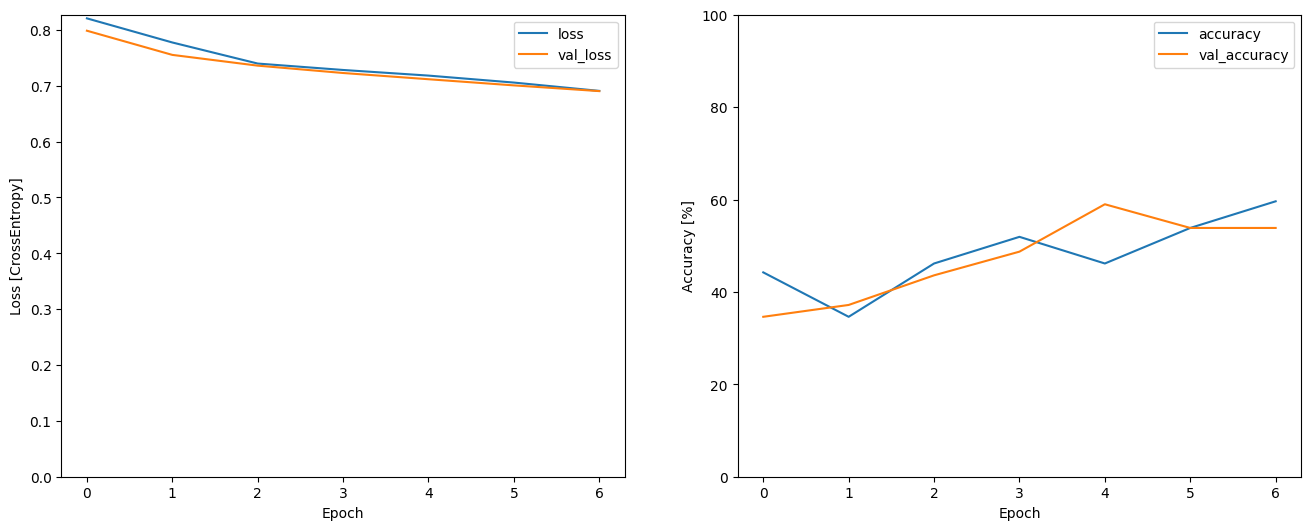

In [8]:
model_mfcc_conv = get_conv_model_mini(input_shape, len(label_names))
model_mfcc_conv.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)
history_mfcc_conv = model_mfcc_conv.fit(
    train_mfccs_ds, 
    validation_data=val_mfccs_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(history_mfcc_conv)

## Raw - Spectrograms

(118, 129, 1)


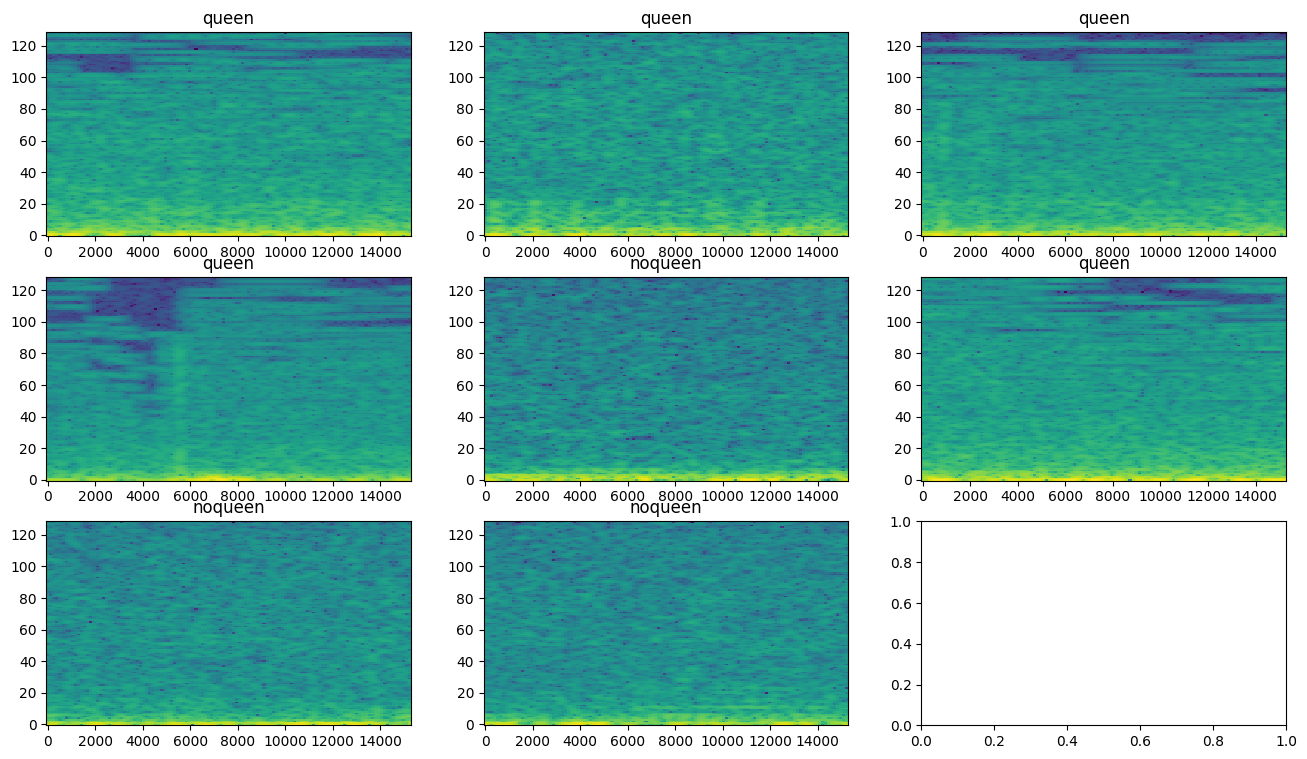

In [9]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break
# (TensorShape([118, 129, 1])
input_shape = example_spectrograms.shape[1:]
print(input_shape)
plot_spectrograms(example_spectrograms, example_spect_labels, label_names)

In [10]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

### [Reinf:Raw] [Spec] Sequential model

Epoch 1/20
7/7 [==============================] - 1s 61ms/step - loss: 0.7014 - accuracy: 0.5192 - val_loss: 0.6682 - val_accuracy: 0.6026
Epoch 2/20
7/7 [==============================] - 0s 20ms/step - loss: 0.6525 - accuracy: 0.5577 - val_loss: 0.6642 - val_accuracy: 0.6026
Epoch 3/20
7/7 [==============================] - 0s 19ms/step - loss: 0.6379 - accuracy: 0.5577 - val_loss: 0.6610 - val_accuracy: 0.6026
Epoch 4/20
7/7 [==============================] - 0s 19ms/step - loss: 0.6202 - accuracy: 0.5000 - val_loss: 0.6574 - val_accuracy: 0.6026
Epoch 5/20
7/7 [==============================] - 0s 19ms/step - loss: 0.6141 - accuracy: 0.4808 - val_loss: 0.6535 - val_accuracy: 0.3077
Epoch 6/20
7/7 [==============================] - 0s 22ms/step - loss: 0.6030 - accuracy: 0.5192 - val_loss: 0.6517 - val_accuracy: 0.3077


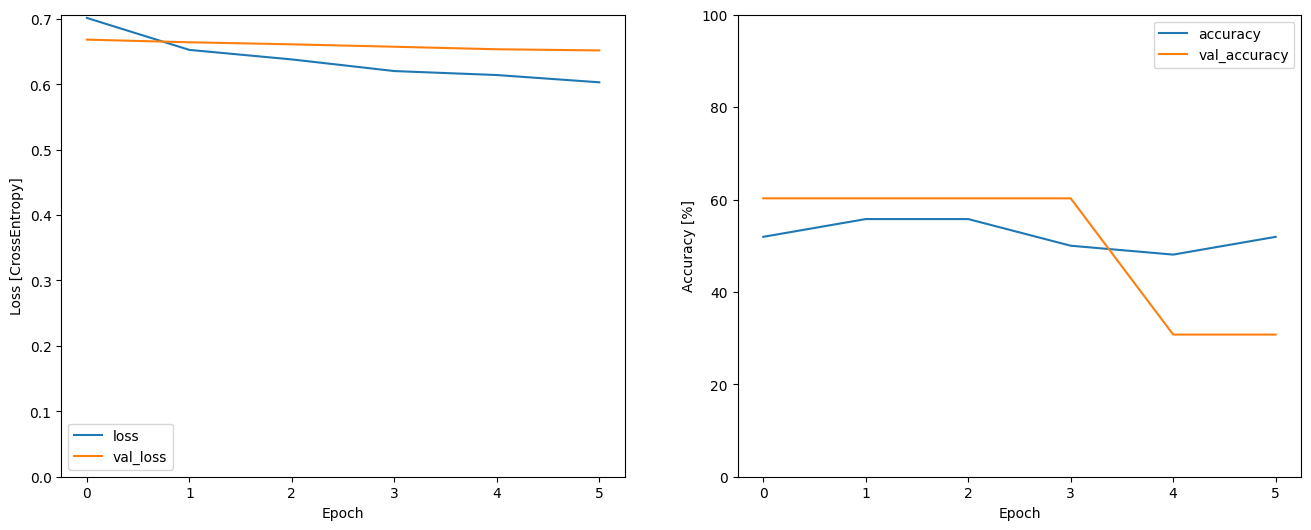

In [11]:
model_spec_seq = get_seq_model(input_shape, len(label_names), train_spectrogram_ds)
model_spec_seq.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
history_spec_seq = model_spec_seq.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=20,
    callbacks=callbacks
)
plot_history(history_spec_seq)

### [Reinf:Raw] [Spec] Convolutional model

Epoch 1/20
7/7 [==============================] - 1s 55ms/step - loss: 0.6843 - accuracy: 0.4423 - val_loss: 0.6567 - val_accuracy: 0.6026
Epoch 2/20
7/7 [==============================] - 0s 13ms/step - loss: 0.6506 - accuracy: 0.5577 - val_loss: 0.6489 - val_accuracy: 0.6026
Epoch 3/20
7/7 [==============================] - 0s 13ms/step - loss: 0.6336 - accuracy: 0.5577 - val_loss: 0.6482 - val_accuracy: 0.6026
Epoch 4/20
7/7 [==============================] - 0s 11ms/step - loss: 0.6268 - accuracy: 0.5577 - val_loss: 0.6465 - val_accuracy: 0.6026
Epoch 5/20
7/7 [==============================] - 0s 12ms/step - loss: 0.6227 - accuracy: 0.5577 - val_loss: 0.6455 - val_accuracy: 0.6026
Epoch 6/20
7/7 [==============================] - 0s 12ms/step - loss: 0.6173 - accuracy: 0.5577 - val_loss: 0.6401 - val_accuracy: 0.6026


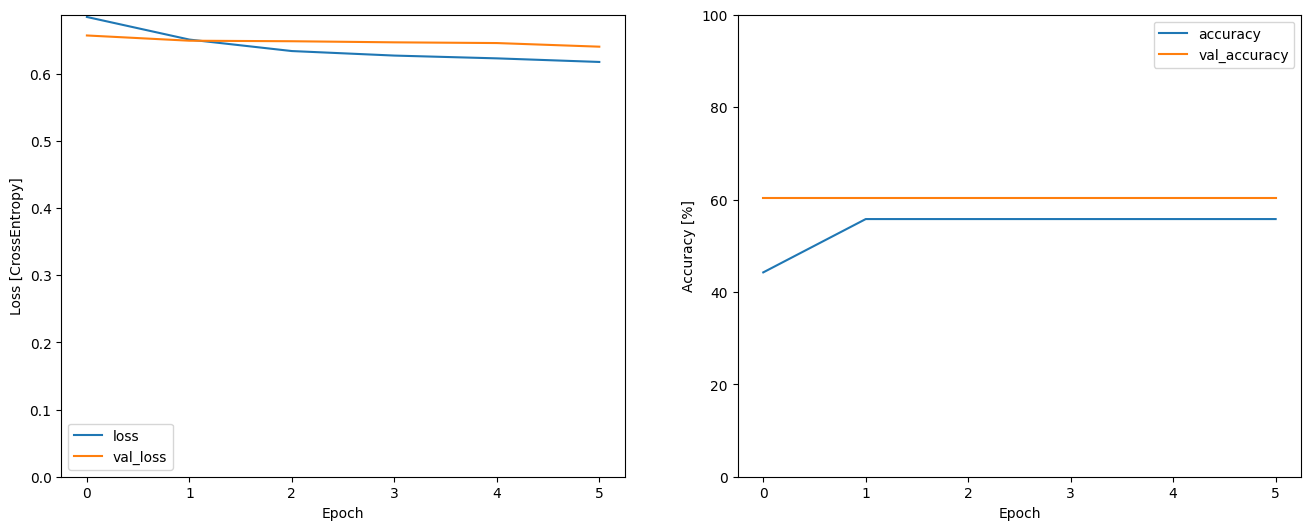

In [12]:
model_spec_conv = get_conv_model(input_shape, len(label_names))
model_spec_conv.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)
history_spec_conv = model_spec_conv.fit(
    train_spectrogram_ds, 
    validation_data=val_spectrogram_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(history_spec_conv)

# Pre-trained models

In [13]:
trained_model_mfcc_seq = tf.keras.models.load_model("models/mfcc_seq.h5")
trained_model_mfcc_conv = tf.keras.models.load_model("models/mfcc_conv_mini.h5")
trained_model_spec_seq = tf.keras.models.load_model("models/spec_seq.h5")
trained_model_spec_conv = tf.keras.models.load_model("models/spec_conv.h5")

In [14]:
results = trained_model_mfcc_seq.evaluate(val_mfccs_ds)
print(f"MFCC Seq: {results}")
results = trained_model_mfcc_conv.evaluate(val_mfccs_ds)
print(f"MFCC Conv: {results}")
results = trained_model_spec_seq.evaluate(val_spectrogram_ds)
print(f"Spec Seq: {results}")
results = trained_model_spec_conv.evaluate(val_spectrogram_ds)
print(f"Spec Conv: {results}")

10/10 [==============================] - 0s 10ms/step - loss: 1.4475 - accuracy: 0.3974
MFCC Seq: [1.4474730491638184, 0.39743590354919434]
10/10 [==============================] - 0s 7ms/step - loss: 0.9365 - accuracy: 0.3718
MFCC Conv: [0.9364808201789856, 0.3717948794364929]
10/10 [==============================] - 0s 10ms/step - loss: 1.7555 - accuracy: 0.3974
Spec Seq: [1.755462884902954, 0.39743590354919434]
10/10 [==============================] - 0s 8ms/step - loss: 2.3728 - accuracy: 0.3974
Spec Conv: [2.3727705478668213, 0.39743590354919434]


### [Reinf] [MFCCs] Sequential model

Epoch 1/20
7/7 [==============================] - 1s 34ms/step - loss: 1.7720 - accuracy: 0.3462 - val_loss: 1.1455 - val_accuracy: 0.5769
Epoch 2/20
7/7 [==============================] - 0s 19ms/step - loss: 1.4020 - accuracy: 0.4615 - val_loss: 0.7681 - val_accuracy: 0.5513
Epoch 3/20
7/7 [==============================] - 0s 20ms/step - loss: 1.0355 - accuracy: 0.6346 - val_loss: 0.8321 - val_accuracy: 0.6026
Epoch 4/20
7/7 [==============================] - 0s 20ms/step - loss: 0.8679 - accuracy: 0.6731 - val_loss: 0.7627 - val_accuracy: 0.5769
Epoch 5/20
7/7 [==============================] - 0s 19ms/step - loss: 0.6623 - accuracy: 0.7500 - val_loss: 0.6810 - val_accuracy: 0.6410
Epoch 6/20
7/7 [==============================] - 0s 19ms/step - loss: 0.5297 - accuracy: 0.7500 - val_loss: 0.5837 - val_accuracy: 0.7308
Epoch 7/20
7/7 [==============================] - 0s 19ms/step - loss: 0.4753 - accuracy: 0.8077 - val_loss: 0.5536 - val_accuracy: 0.7436
Epoch 8/20
7/7 [===========

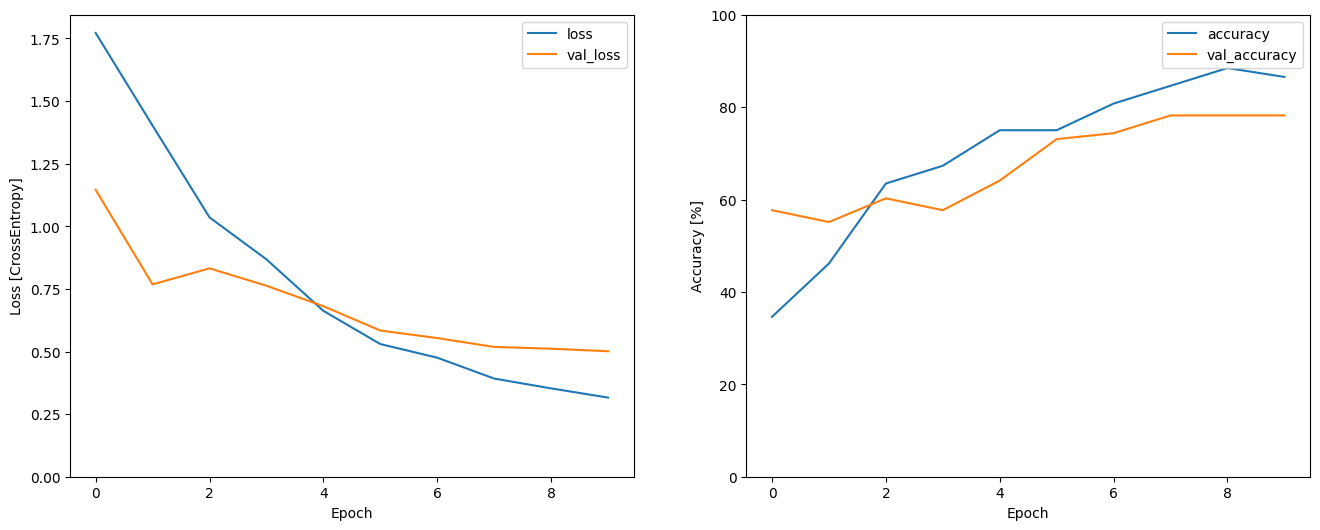

In [15]:
trained_history_mfcc_seq = trained_model_mfcc_seq.fit(
    train_mfccs_ds, 
    validation_data=val_mfccs_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(trained_history_mfcc_seq)

### [Reinf] [MFCCs] Convolutional model (mini)

Epoch 1/20


7/7 [==============================] - 0s 24ms/step - loss: 0.9782 - accuracy: 0.4231 - val_loss: 0.7494 - val_accuracy: 0.5385
Epoch 2/20
7/7 [==============================] - 0s 11ms/step - loss: 0.8277 - accuracy: 0.5192 - val_loss: 0.7126 - val_accuracy: 0.5385
Epoch 3/20
7/7 [==============================] - 0s 10ms/step - loss: 0.7397 - accuracy: 0.6154 - val_loss: 0.6309 - val_accuracy: 0.6795
Epoch 4/20
7/7 [==============================] - 0s 10ms/step - loss: 0.7332 - accuracy: 0.5769 - val_loss: 0.5839 - val_accuracy: 0.7051
Epoch 5/20
7/7 [==============================] - 0s 9ms/step - loss: 0.6237 - accuracy: 0.7115 - val_loss: 0.6036 - val_accuracy: 0.6410
Epoch 6/20
7/7 [==============================] - 0s 10ms/step - loss: 0.5996 - accuracy: 0.6923 - val_loss: 0.5157 - val_accuracy: 0.7692
Epoch 7/20
7/7 [==============================] - 0s 10ms/step - loss: 0.5998 - accuracy: 0.6346 - val_loss: 0.4864 - val_accuracy: 0.8205


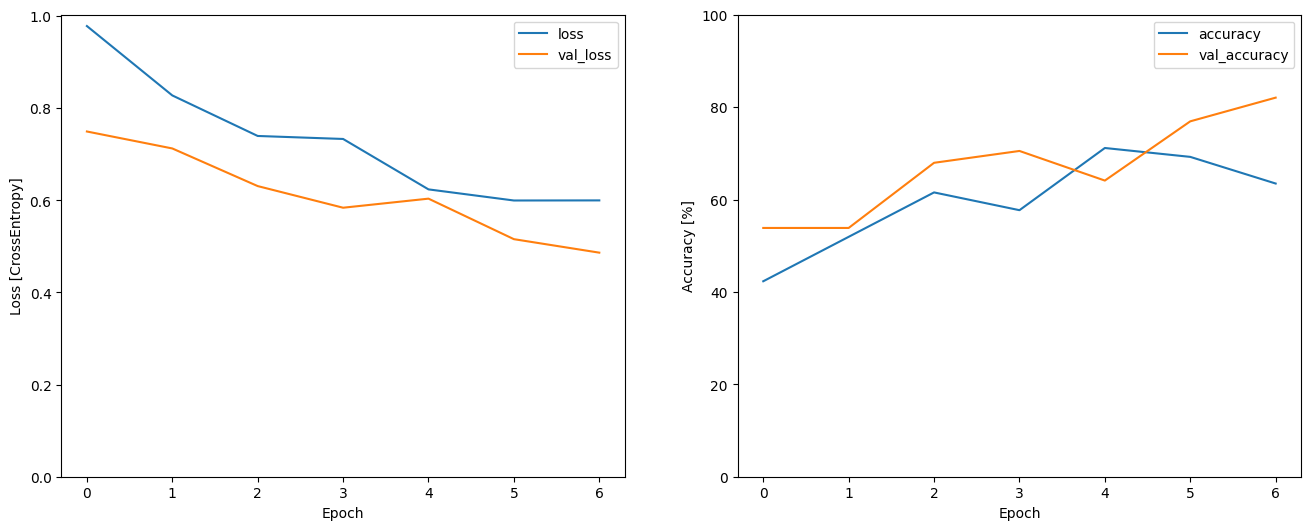

In [16]:
trained_history_mfcc_conv = trained_model_mfcc_conv.fit(
    train_mfccs_ds, 
    validation_data=val_mfccs_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(trained_history_mfcc_conv)

### [Reinf] [Spec] Sequential model

Epoch 1/20
7/7 [==============================] - 1s 34ms/step - loss: 1.4778 - accuracy: 0.5000 - val_loss: 0.6031 - val_accuracy: 0.5385
Epoch 2/20
7/7 [==============================] - 0s 20ms/step - loss: 0.9326 - accuracy: 0.5385 - val_loss: 0.7231 - val_accuracy: 0.6154
Epoch 3/20
7/7 [==============================] - 0s 20ms/step - loss: 0.8745 - accuracy: 0.5769 - val_loss: 0.5414 - val_accuracy: 0.6026
Epoch 4/20
7/7 [==============================] - 0s 20ms/step - loss: 0.6782 - accuracy: 0.6538 - val_loss: 0.6852 - val_accuracy: 0.6923
Epoch 5/20
7/7 [==============================] - 0s 20ms/step - loss: 0.6925 - accuracy: 0.6538 - val_loss: 0.5778 - val_accuracy: 0.6923
Epoch 6/20
7/7 [==============================] - 0s 20ms/step - loss: 0.6025 - accuracy: 0.6731 - val_loss: 0.5353 - val_accuracy: 0.5897


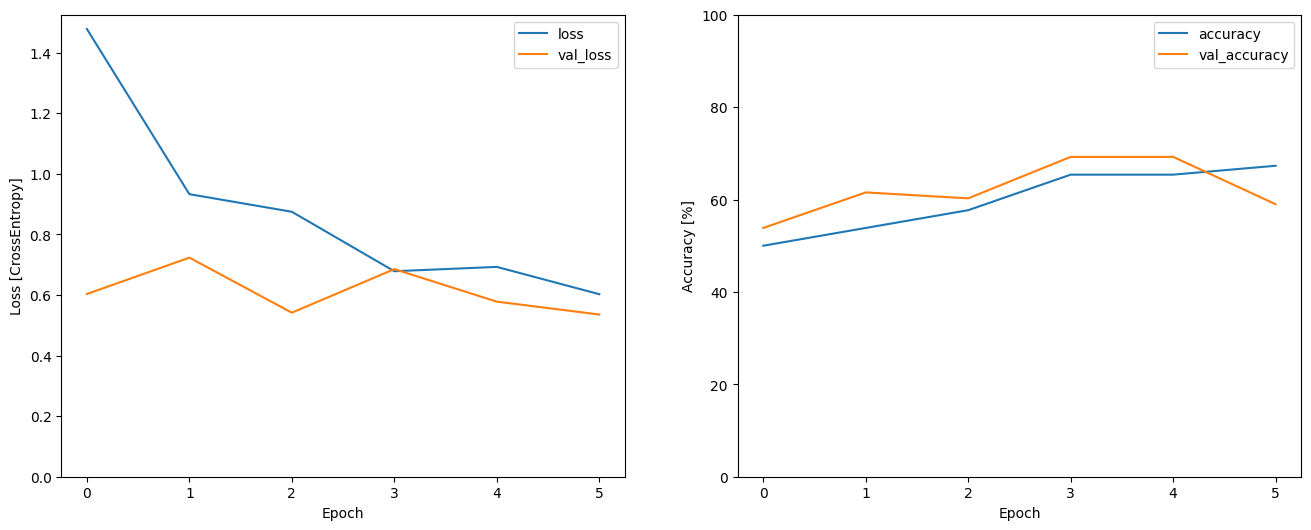

In [17]:
trained_history_spec_seq = trained_model_spec_seq.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(trained_history_spec_seq)

### [Reinf] [Spec] Convolutional model

Epoch 1/20
7/7 [==============================] - 0s 28ms/step - loss: 1.9597 - accuracy: 0.4423 - val_loss: 1.0870 - val_accuracy: 0.4103
Epoch 2/20
7/7 [==============================] - 0s 15ms/step - loss: 0.8324 - accuracy: 0.4423 - val_loss: 0.6104 - val_accuracy: 0.6154
Epoch 3/20
7/7 [==============================] - 0s 12ms/step - loss: 0.7556 - accuracy: 0.5577 - val_loss: 0.7674 - val_accuracy: 0.6026
Epoch 4/20
7/7 [==============================] - 0s 11ms/step - loss: 0.8018 - accuracy: 0.5577 - val_loss: 0.7706 - val_accuracy: 0.6026
Epoch 5/20
7/7 [==============================] - 0s 11ms/step - loss: 0.7630 - accuracy: 0.5577 - val_loss: 0.7147 - val_accuracy: 0.6026
Epoch 6/20
7/7 [==============================] - 0s 11ms/step - loss: 0.7066 - accuracy: 0.5577 - val_loss: 0.6529 - val_accuracy: 0.6026


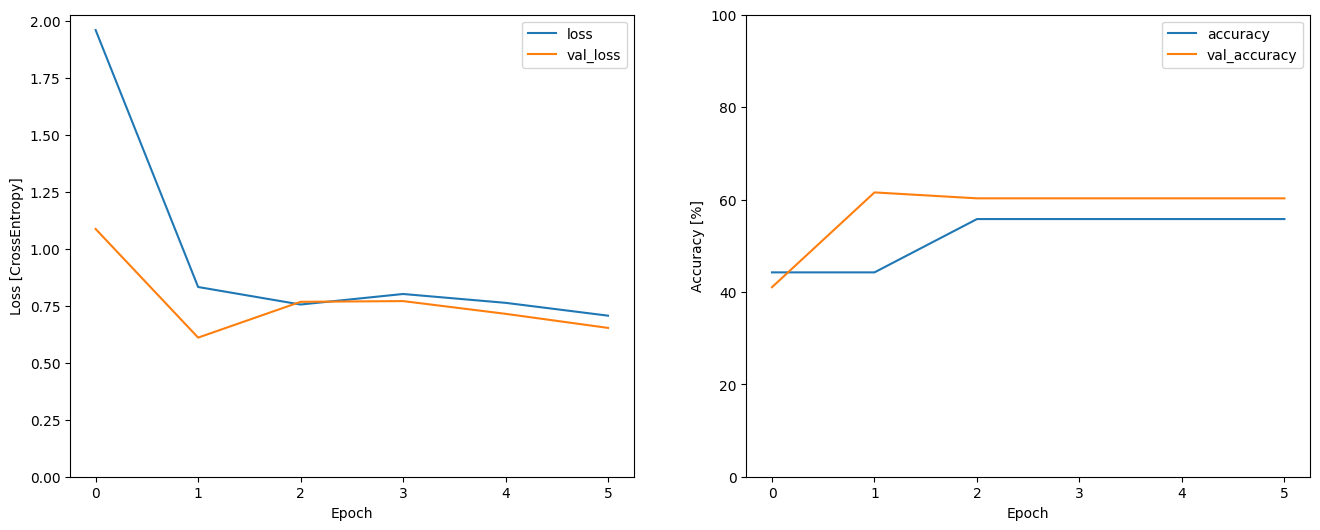

In [18]:
trained_history_spec_conv = trained_model_spec_conv.fit(
    train_spectrogram_ds, 
    validation_data=val_spectrogram_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(trained_history_spec_conv)

# Save models

In [19]:
trained_model_mfcc_seq.save('models/renf_mfcc_seq.h5')
trained_model_mfcc_conv.save('models/renf_mfcc_conv.h5')
trained_model_spec_seq.save('models/renf_spec_seq.h5')
trained_model_spec_conv.save('models/renf_spec_conv.h5')

/Users/lantain/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Summary

In [20]:
def history_to_summary(prefix: str, history):
    print(f"{prefix}:    Loss: {history.history['loss'][-1]:.2f}, Acc: {history.history['accuracy'][-1]:.2f}, VLoss: {history.history['val_loss'][-1]:.2f}, VAcc: {history.history['val_accuracy'][-1]:.2f}" )

print("=== RAW ===")
history_to_summary("MFCCs + Seq       ", history_mfcc_seq)
history_to_summary("MFCCs + Conv      ", history_mfcc_conv)
history_to_summary("Spectrogram + Seq ", history_spec_seq)
history_to_summary("Spectrogram + Conv", history_spec_conv)
print("")
print("=== TRAINED ===")
history_to_summary("Tr. MFCCs + Seq       ", trained_history_mfcc_seq)
history_to_summary("Tr. MFCCs + Conv      ", trained_history_mfcc_conv)
history_to_summary("Tr. Spectrogram + Seq ", trained_history_spec_seq)
history_to_summary("Tr. Spectrogram + Conv", trained_history_spec_conv)


=== RAW ===
MFCCs + Seq       :    Loss: 0.58, Acc: 0.71, VLoss: 0.63, VAcc: 0.60
MFCCs + Conv      :    Loss: 0.69, Acc: 0.60, VLoss: 0.69, VAcc: 0.54
Spectrogram + Seq :    Loss: 0.60, Acc: 0.52, VLoss: 0.65, VAcc: 0.31
Spectrogram + Conv:    Loss: 0.62, Acc: 0.56, VLoss: 0.64, VAcc: 0.60

=== TRAINED ===
Tr. MFCCs + Seq       :    Loss: 0.32, Acc: 0.87, VLoss: 0.50, VAcc: 0.78
Tr. MFCCs + Conv      :    Loss: 0.60, Acc: 0.63, VLoss: 0.49, VAcc: 0.82
Tr. Spectrogram + Seq :    Loss: 0.60, Acc: 0.67, VLoss: 0.54, VAcc: 0.59
Tr. Spectrogram + Conv:    Loss: 0.71, Acc: 0.56, VLoss: 0.65, VAcc: 0.60
